## Cell Competition Gastruloids
### Bulk RNA-Seq timecourse analysis


In [1]:
# load packages
import pandas as pd
import os
import glob

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.lines as mlines
import textwrap
from adjustText import adjust_text

import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm

import warnings
warnings.filterwarnings("ignore")

from custom_functions import *


save_format = "svg"

In [2]:
# paths
data='data/'

# output folders
results='results'

subfolders=['preprocessing','de','genelists', 'figures']

for s in subfolders:
    os.makedirs(f'{results}/{s}', exist_ok=True)

## 0. Load counts and metadata

In [3]:
#Counts
rawcounts = pd.read_csv(f'{data}/cell_comp_bulk.csv',index_col=0).T
rawcounts = rawcounts.loc[:,~rawcounts.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [4]:
# #Counts
# rawcounts = pd.read_csv(f'{data}/cell_comp_epis.csv',index_col=0).T
# rawcounts = rawcounts.loc[:,~rawcounts.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [5]:
ww=rawcounts.loc[[i for i in rawcounts.index.values if 'WW' in i],:]
kk=ww=rawcounts.loc[[i for i in rawcounts.index.values if 'KK' in i],:]
ww.to_csv('results/clust/Input_files_and_params/Data/ww_counts.txt',sep='\t')
kk.to_csv('results/clust/Input_files_and_params/Data/kk_counts.txt', sep='\t')

In [6]:
#Metadata
meta = pd.read_csv(f"{data}/metadata_cell_comp.csv",index_col=0)
meta.head()

,Condition
WW0002,WW000
WW0003,WW000
WW0004,WW000
KF0002,KF000
KF0003,KF000


In [7]:
meta['Clone'] = meta['Condition'].str.extract(r'^([A-Za-z]+)')
meta['Time'] = meta['Condition'].str.extract(r'^[A-Za-z]+(\d{3})')+'h'
meta.head()

,Condition,Clone,Time
WW0002,WW000,WW,000h
WW0003,WW000,WW,000h
WW0004,WW000,WW,000h
KF0002,KF000,KF,000h
KF0003,KF000,KF,000h


# Preprocessing and QC

In [8]:
print(f"Samples in dataset: {rawcounts.shape[0]}")
print(f"Genes in dataset: {rawcounts.shape[1]}")

Samples in dataset: 72
Genes in dataset: 55367


In [9]:
# Removing genes that are not expressed in any sample
counts=rawcounts.loc[:,rawcounts.sum()>0]

print(f'Genes kept: {counts.shape[1]}')

Genes kept: 42271


**LIBRARY SIZES**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


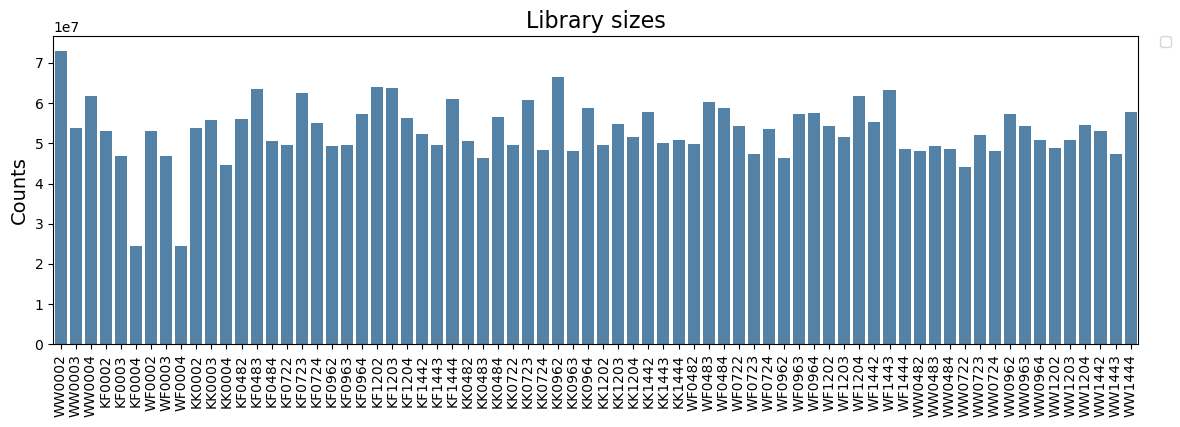

In [10]:
fig,ax=plt.subplots(1,1,figsize=(14,4))
sns.barplot(counts, x=counts.index, y=counts.sum(axis=1),ax=ax,color='steelblue')

plt.xticks(rotation=90)
plt.title('Library sizes', size=16)
plt.ylabel('Counts', size=14)
plt.xlabel('')

# create result folder
plt.savefig(f"results/preprocessing/library_sizes.{save_format}", bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

## Scaling: Normalized counts

Size factor normalization by median of ratios (DESeq2).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


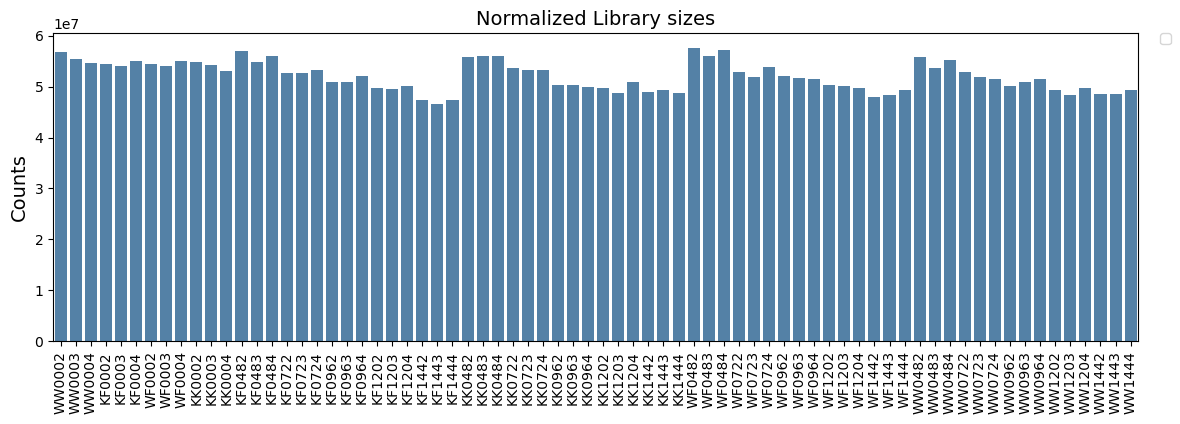

In [11]:
# run deseq2_norm function
norm_counts=deseq2_norm(counts)[0]

fig,ax=plt.subplots(1,1,figsize=(14,4))
sns.barplot(norm_counts, x=norm_counts.index, y=norm_counts.sum(axis=1),ax=ax, color='steelblue')

plt.xticks(rotation=90)
plt.title('Normalized Library sizes', size=14)
plt.ylabel('Counts', size=14)
plt.xlabel('')

# create result folder
plt.savefig(f"results/preprocessing/normalized_library_sizes.{save_format}", bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

# save normalized counts table
norm_counts.T.to_csv(f"data/normalized_counts.csv")

# 1. Analysis

## Construct DESeq2 object

In [12]:
dds = DeseqDataSet(
    counts=counts.values,
    metadata=meta,
    design_factors="Condition",
    refit_cooks=True
)
dds.var_names=counts.columns

## Variance Stabilizing Transformation (VST)

Normalization of non-homoskedastic data. VST improves log1p performance, which overweights low count genes.

In [13]:
# run vst algorithm, saved in .layers
dds.vst()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 8.31 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.



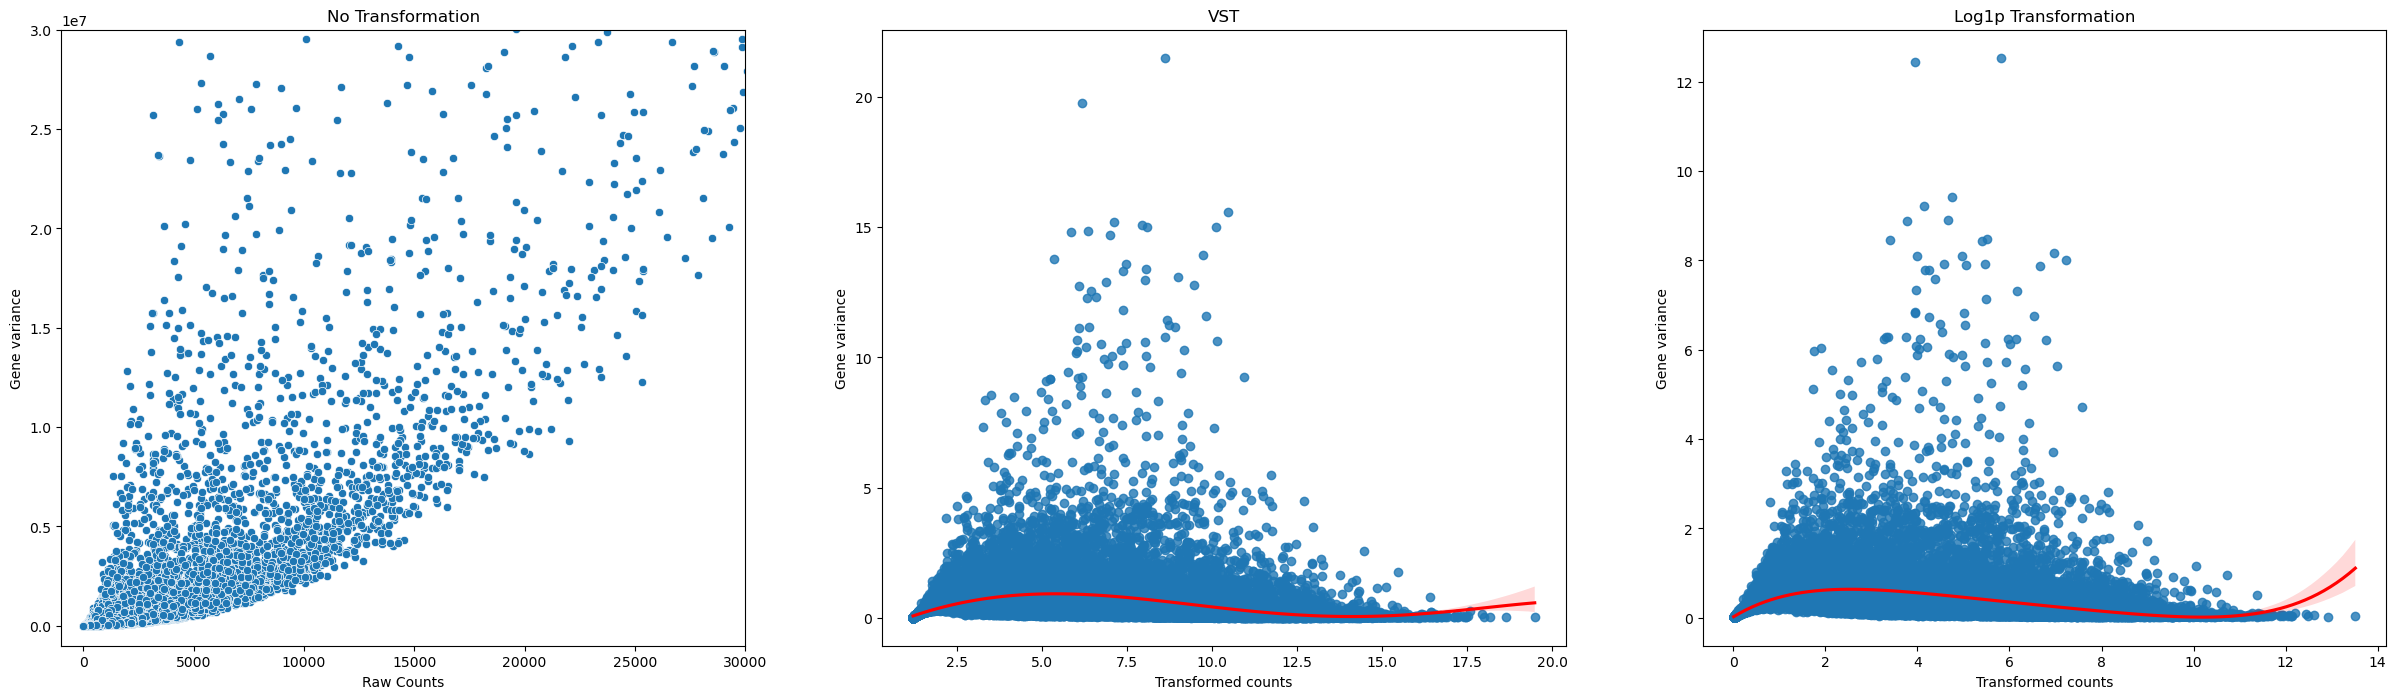

In [14]:

fig,ax = plt.subplots(1,3, figsize=(30,8))
# non-normalized counts
sns.scatterplot(data=counts, x=counts.mean(), y=counts.var(), ax=ax[0])
ax[0].set_ylim(-10e5,3*10e6)
ax[0].set_xlim(-10e2, 30000)
ax[0].set_ylabel('Gene variance')
ax[0].set_xlabel('Raw Counts')
ax[0].set_title('No Transformation')

# vst transformed counts
sns.regplot(x=dds.layers['vst_counts'].mean(axis=0), y=dds.layers['vst_counts'].var(axis=0),ax=ax[1],order=5, line_kws=dict(color="r"))
ax[1].set_ylabel('Gene variance')
ax[1].set_xlabel('Transformed counts')
ax[1].set_title('VST')

# log1p transformed counts
sns.regplot(x=np.log1p(counts).mean(axis=0), y=np.log1p(counts).var(axis=0),ax=ax[2],order=5, line_kws=dict(color="r"))
ax[2].set_ylabel('Gene variance')
ax[2].set_xlabel('Transformed counts')
ax[2].set_title('Log1p Transformation')

# save plot
plt.savefig(f'{results}/figures/benchmarking_count_transformation.{save_format}', bbox_inches='tight')

**Once run, VST and Log1p offer similar resource. Time and resource-wise, log1p is going to be used**

## Log transformation

In [15]:
logcounts=np.log1p(norm_counts)

In [16]:
# create df with transformed counts
df= pd.DataFrame(data=logcounts,    
             index=dds.obs.index,    
            columns=counts.columns.values)

## Feature selection

We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

### Subset samples for comparisons

In [17]:
df_=df.copy()

fs = VarianceThreshold(threshold=1)
fs.fit(df_.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

print(f"Genes retained: {len(l)}")

Genes retained: 1750


## PCA

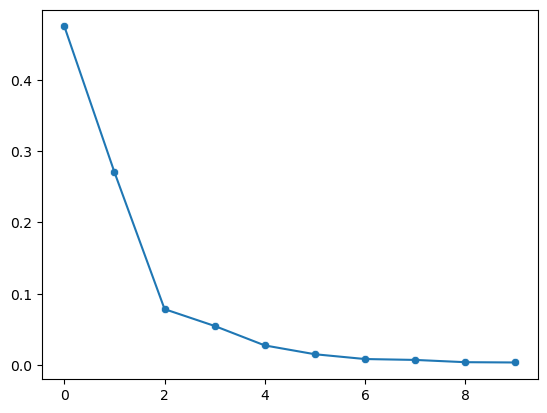

In [18]:
df_fs = pd.DataFrame(fs.transform(df_.values),index=df_.index,columns=df_.columns.values[l])
pca = PCA(n_components=10)
pca.fit(df_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

# save plot
plt.savefig(f'{results}/figures/explained_variance_by_pca.{save_format}')

In [19]:
names = df_.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]] # get gene names for most variant
df_fs = pd.DataFrame(fs.transform(df_.values),index=df_.index,columns=names)
pca = PCA(n_components=min(df_.shape[0]-1,10))
pca.fit(fs.transform(df.values));

In [20]:
# pca transform
x = pca.transform(fs.transform(df_.values))

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

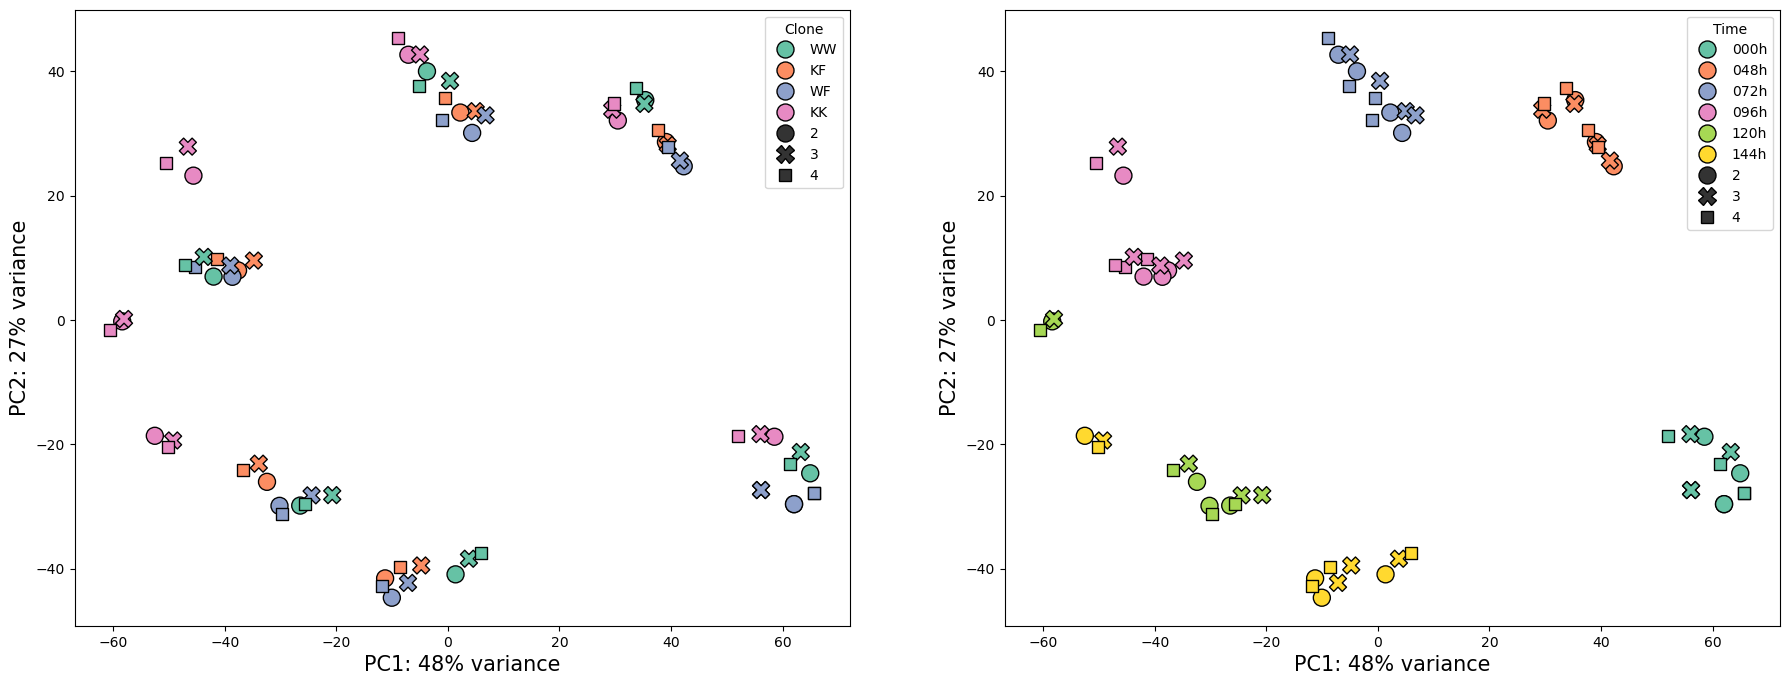

In [21]:
fig,ax=plt.subplots(1,2,figsize=(22,8))
sns.scatterplot(x=x[:,0], y=x[:,1], s=150, edgecolor='black',hue=meta['Clone'], ax=ax[0], palette='Set2', style=[b[-1] for b in df_.index])
sns.scatterplot(x=x[:,0], y=x[:,1], s=150, edgecolor='black',hue=meta['Time'], ax=ax[1], palette='Set2', style=[b[-1] for b in df_.index])

# axes
ax[0].set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax[0].set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

ax[1].set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax[1].set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)


plt.savefig(f"{results}/figures/pca_scatterplot_clone_time.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

Showing which genes have a higher weight in the space descirption of the comparison

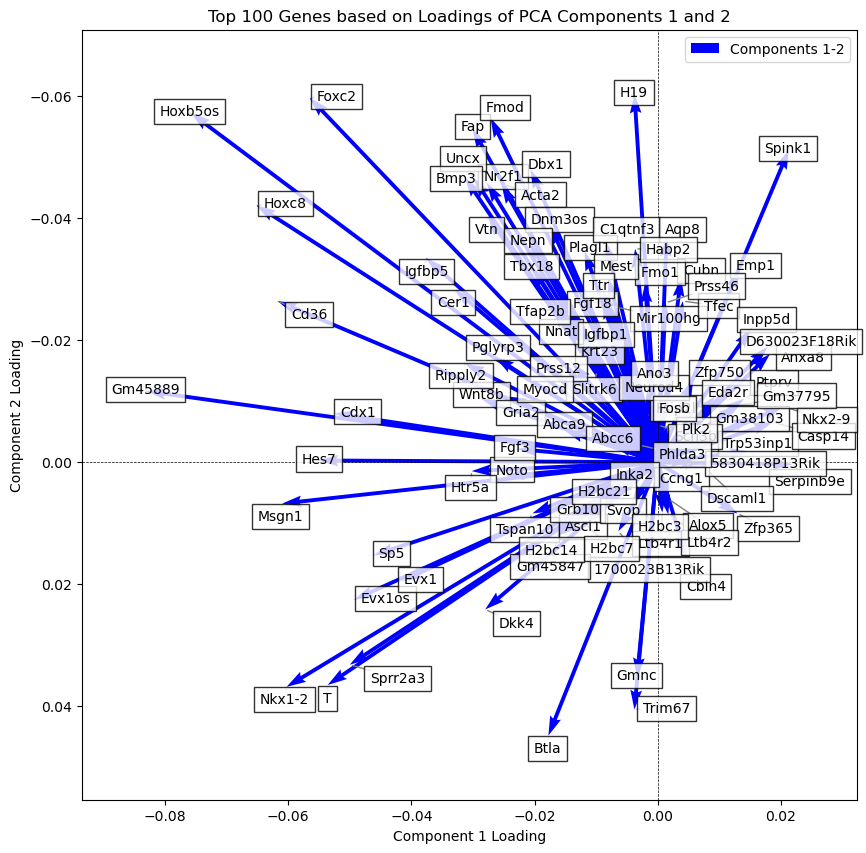

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df_fs.columns.values,100,ax)
#ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig(f"results/figures/pca_loadings.{save_format}",bbox_inches="tight",transparent=True)

# save gene list
loadings_genelist(pca,0,1,features=df_fs.columns.values,n_genes=100, path=f'{results}/genelists')

# Hox genes expression pattern

In [23]:
# sort rows by 
column_order = sorted(df.index, key=lambda x: int(x[2:5]))
df_time = df.loc[column_order]
df_time

,Xkr4,Gm37180,Gm37363,Gm37686,Gm37329,Gm7341,Gm38148,Gm19938,Gm10568,Gm37381,...,CAAA01147332.1,AC165294.1,AC165294.2,AC123873.1,AC126035.1,AC163611.1,AC140365.1,AC133095.2,AC133095.1,AC149090.1
WW0002,1.412790,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,4.739877,0.0,0.000000,0.0,0.000000,3.252667,4.733064,4.705340,0.000000,9.376628
WW0003,2.327339,0.0,0.0,0.0,0.0,0.0,0.0,0.706975,0.0,0.000000,...,4.469800,0.0,0.000000,0.0,0.000000,2.590330,4.185927,3.938948,0.000000,9.299840
WW0004,1.971275,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.632777,...,4.696731,0.0,0.000000,0.0,0.000000,3.099551,4.612742,4.207858,0.000000,9.313026
KF0002,2.327901,0.0,0.0,0.0,0.0,0.0,0.0,0.707291,0.0,0.000000,...,5.461691,0.0,0.707291,0.0,0.000000,3.610839,5.163725,4.527592,0.000000,9.217204
KF0003,2.617333,0.0,0.0,0.0,0.0,0.0,0.0,0.767544,0.0,0.767544,...,5.217976,0.0,0.000000,0.0,0.000000,3.636084,5.284520,4.459342,0.000000,9.072394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WF1443,2.999384,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,6.098127,0.0,0.000000,0.0,0.000000,2.457961,4.337679,4.151984,0.000000,9.204517
WF1444,3.414777,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,6.020363,0.0,0.000000,0.0,0.000000,2.652105,4.124690,4.002770,0.000000,9.156211
WW1442,2.404651,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,5.729503,0.0,0.000000,0.0,0.000000,2.912433,4.557392,4.423987,0.000000,9.400704
WW1443,2.421145,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,5.963015,0.0,0.000000,0.0,0.706001,2.731913,4.369023,3.762614,0.706001,9.364980


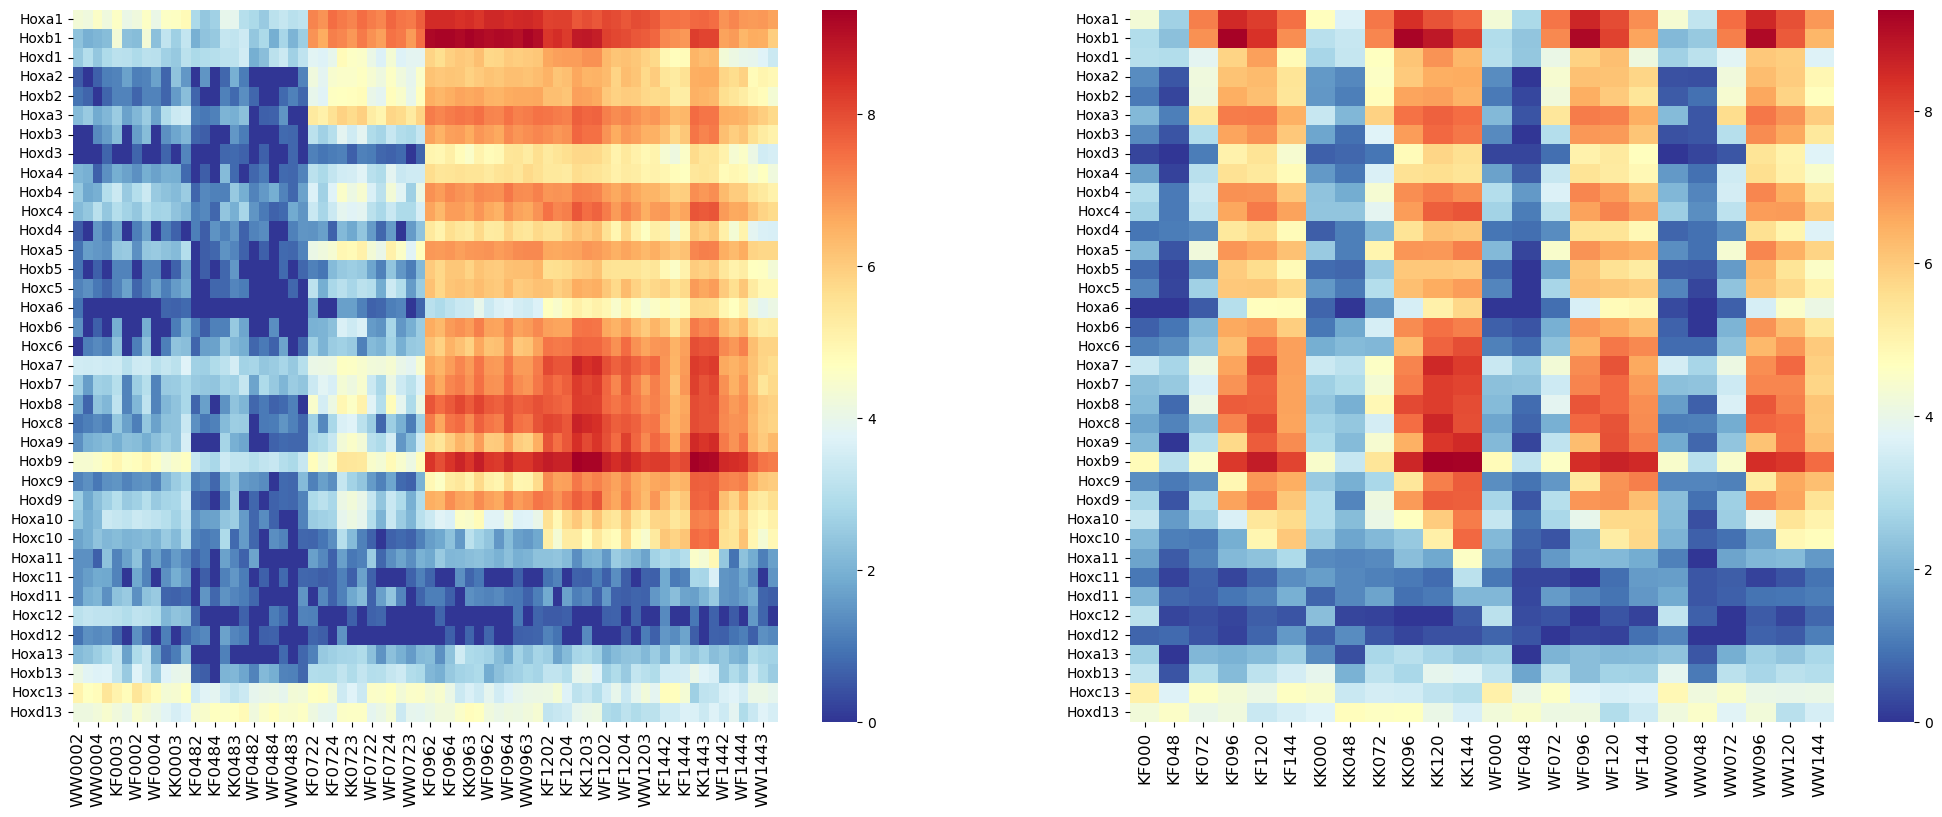

In [24]:
hox=pd.read_excel('markers.xlsx', sheet_name='hox_genes', header=None)[0].tolist()
plot_heatmap_markers(data=df_time, markers=hox,filename='cellcomp_hox', figsize=(25,len(hox)/4))

# DIFFERENTIAL EXPRESSION

Wald test in pair-wise comparison to explore differential expressed genes

In [25]:
# run DESeq2 function on dds object
dds.deseq2()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 8.73 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 12.77 seconds.

Fitting LFCs...
... done in 7.68 seconds.

Replacing 0 outlier genes.



### Gene ranking and DEGs

1) Running Wald-test for each comparison
2) Subsetting DEGs accoridng to threholds
3) Heatmap plotting top DEGs 

### PAIR-WISE COMPARISON

In [34]:
comparisons = [
    # 0h
    ('KF000', 'WF000'),('WF000', 'WW000'), ('KF000', 'WW000'),('KK000', 'KF000'), ('KK000', 'WW000'),
    # 48h
    ('WF048', 'WW048'), ('KF048', 'WW048'), ('KK048', 'WW048'), 
    ('KF048', 'WF048'), ('KK048', 'WF048'), ('KK048', 'KF048'),
    # 72h
    ('WF072', 'WW072'), ('KF072', 'WW072'), ('KK072', 'WW072'), 
    ('KF072', 'WF072'), ('KK072', 'WF072'), ('KK072', 'KF072'),
    # 96h
    ('WF096', 'WW096'), ('KF096', 'WW096'), ('KK096', 'WW096'), 
    ('KF096', 'WF096'), ('KK096', 'WF096'), ('KK096', 'KF096'),
    # 120h
    ('WF120', 'WW120'), ('KF120', 'WW120'), ('KK120', 'WW120'), 
    ('KF120', 'WF120'), ('KK120', 'WF120'), ('KK120', 'KF120'),
    # 144h
    ('WF144', 'WW144'), ('KF144', 'WW144'), ('KK144', 'WW144'), 
    ('KF144', 'WF144'), ('KK144', 'WF144'), ('KK144', 'KF144')
]



In [35]:
%%capture 
for c in comparisons:
   stat_res, degs_df = pairwise_comparison(dds, c[0], c[1], lfc_threshold= 1, padj = 0.05, save_format='csv', outdir=f'results/de/{c[0][-3:]}h');



#### Number of degs per timepoint. Exploring 48h-96h timeframe

In [36]:
# timepoints
timepoints = ['000h', '048h', '072h', '096h', '120h', '144h'] 
conditions = [c for c in comparisons] 


In [38]:
# # Create an empty DataFrame to hold the DEG counts
# df_degs = pd.DataFrame(index=timepoints, columns=sorted(set([f"{c1[:-3]}_vs_{c2[:-3]}" for c1, c2 in conditions])))

# # Populate the DataFrame with DEG counts
# for tp in timepoints:
#     for c1, c2 in conditions:
#         c1=c1[:-3]
#         c2=c2[:-3]
#         # Construct file name (assuming files are named in the format "<comparison>_<timepoint>.csv")
#         file_name = f"results/de/{tp}/degs_{c1}{tp[:-1]}_vs_{c2}{tp[:-1]}.csv"
        
#         df_deg = pd.read_csv(file_name)
#         num_degs = len(df_deg)
        
#         # Assign the count to the appropriate cell in the DataFrame
#         df_degs.loc[tp, f"{c1}_vs_{c2}"] = num_degs

# # Fill any missing values with 0 (in case of mismatches)
# df_degs = df_degs.fillna(0).astype(int)

# # Display the DataFrame
# print(df_degs)


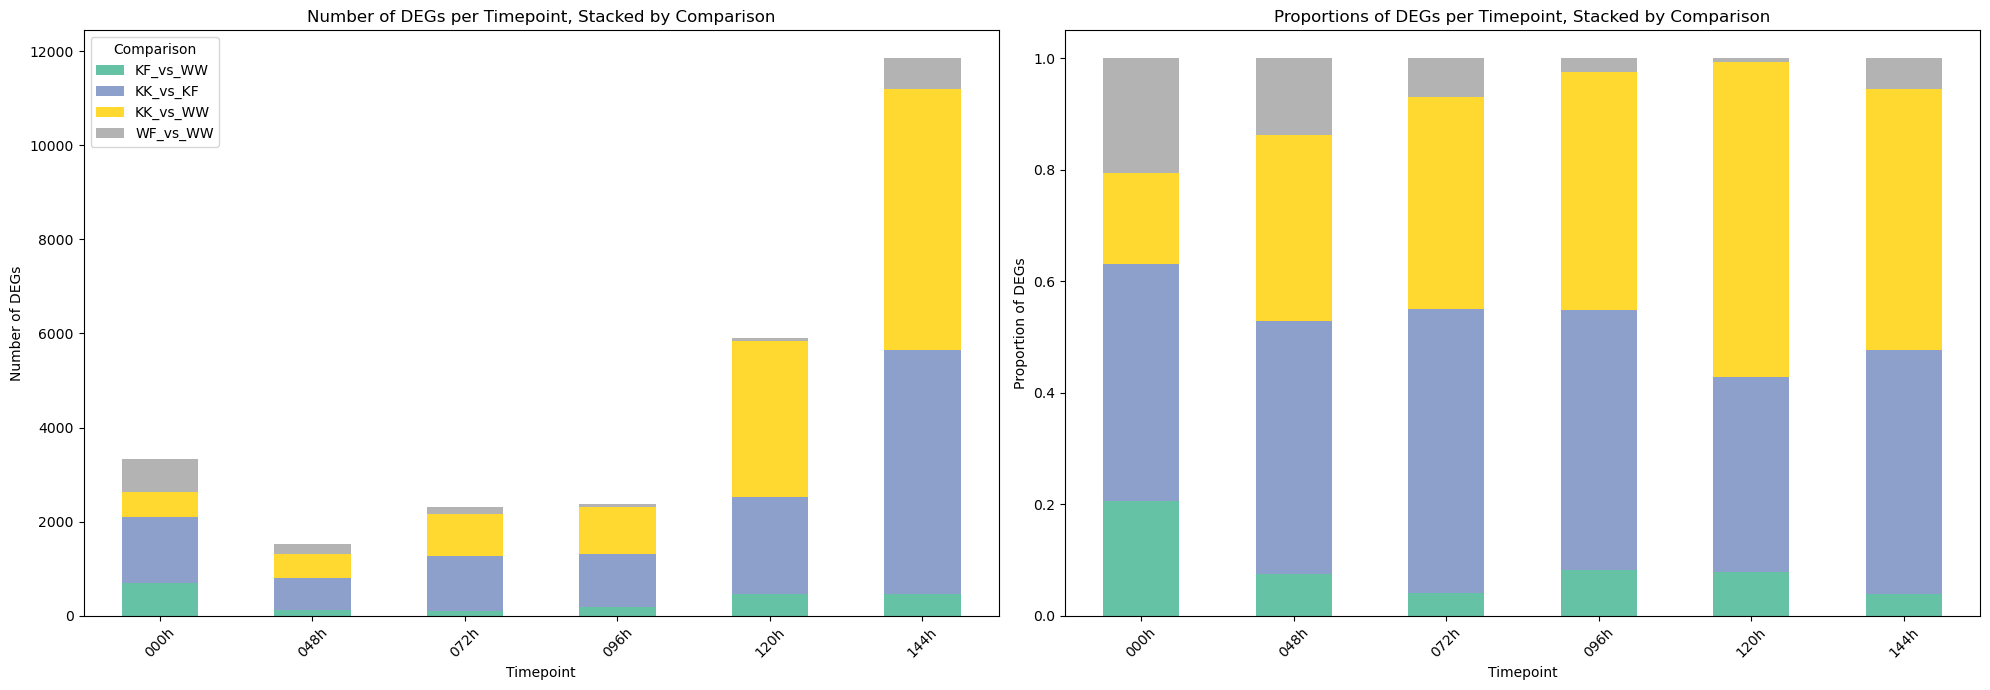

In [ ]:
# Melt the DataFrame to long format
df_melted = df_degs.reset_index().melt(id_vars='index', var_name='Comparison', value_name='DEG_Count')
df_melted.rename(columns={'index': 'Timepoint'}, inplace=True)

# Create a pivot table to get counts per Timepoint and Comparison for stacked bars
df_pivot = df_melted.pivot_table(index='Timepoint', columns='Comparison', values='DEG_Count', aggfunc='sum')

# Calculate proportions (scaled DEGs)
df_proportions = df_pivot.div(df_pivot.sum(axis=1), axis=0)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=False)

# Plot the stacked barplot for absolute DEGs
df_pivot.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2')
axes[0].set_title('Number of DEGs per Timepoint, Stacked by Comparison')
axes[0].set_ylabel('Number of DEGs')
axes[0].set_xlabel('Timepoint')
axes[0].tick_params(axis='x', rotation=45)

# Plot the stacked barplot for proportions
df_proportions.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set2')
axes[1].set_title('Proportions of DEGs per Timepoint, Stacked by Comparison')
axes[1].set_ylabel('Proportion of DEGs')
axes[1].set_xlabel('Timepoint')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig(f'results/figures/deg_number_barplot.{save_format}')


### Marker gene expression

In [ ]:
m=pd.read_excel('markers.xlsx', sheet_name='graph1', header=None)[0].tolist()
#m=pd.read_excel('markers.xlsx', sheet_name='graph2', header=None)[0].tolist()

In [ ]:
# Define the custom order for the 'Clone' column
clone_order = ['KK', 'KF', 'WF', 'WW']

# Assuming 'meta' DataFrame contains the 'Time' and 'Clone' columns
m_df = df.loc[:, m]
m_df['Time'] = meta['Time']
m_df['Clone'] = meta['Clone']

# Slice the DataFrame and sort by 'Clone' with the custom order
m_df['Clone'] = pd.Categorical(m_df['Clone'], categories=clone_order, ordered=True)

# Sort by both 'Clone' and 'Time'
m_df = m_df.sort_values(by=['Clone', 'Time'])

# Display the head of the sorted DataFrame
m_df.head()


,Myc,Trp53,Trp63,Trp73,Cdkn1a,Noxa1,Bbc3,Fas,Fasl,Tnf,...,Tnfrsf1b,Fut4,Pecam1,Nanog,Sox2,Sox3,Foxa2,T,Time,Clone
KK0002,8.172770,7.736926,1.807733,4.672918,6.035249,2.502464,6.121654,0.702762,1.111412,1.111412,...,6.306962,3.779897,8.194680,10.303114,9.994015,4.400928,2.725924,3.950592,000h,KK
KK0003,8.135051,7.820946,1.588656,4.264775,5.940169,1.366824,5.895603,0.000000,1.366824,1.081324,...,6.414943,4.101514,8.544693,10.265626,10.010837,3.845705,2.919781,4.133250,000h,KK
KK0004,8.110674,7.842722,1.753106,4.663392,5.842443,2.647902,6.206872,1.521563,1.753106,1.219723,...,6.322559,4.393701,8.539648,10.226881,10.125746,4.393701,3.213361,4.332927,000h,KK
KK0482,8.025718,7.466076,0.744899,6.388637,4.684944,2.577829,6.124172,0.000000,0.744899,0.000000,...,6.194310,4.664304,7.459089,7.746309,8.974271,7.734764,3.970155,4.273866,048h,KK
KK0483,8.171894,7.537594,1.227667,6.383926,4.489579,2.365845,6.269659,0.791466,1.530370,0.000000,...,6.307752,4.555109,7.360891,7.755605,9.024616,7.868389,4.389964,4.154886,048h,KK


In [ ]:
# Melt df 
# Reshape data to long format
df_long =m_df.melt(id_vars=['Clone', 'Time'], var_name='Gene', value_name='Expression')

custom_colors = {
    'WF': (66/255, 148/255, 248/255),  # Blue (scaled to [0, 1])
    'WW': (240/255, 153/255, 55/255),  # Orange (scaled to [0, 1])
    'KF': (114/255, 245/255, 74/255),  # Green (scaled to [0, 1]) or darker green (108, 232, 70)
    'KK': (234/255, 70/255, 145/255)   # Magenta (scaled to [0, 1])
}
# Assign conditions from the Clone column
df_long['Condition'] = df_long['Clone'].str[:2]


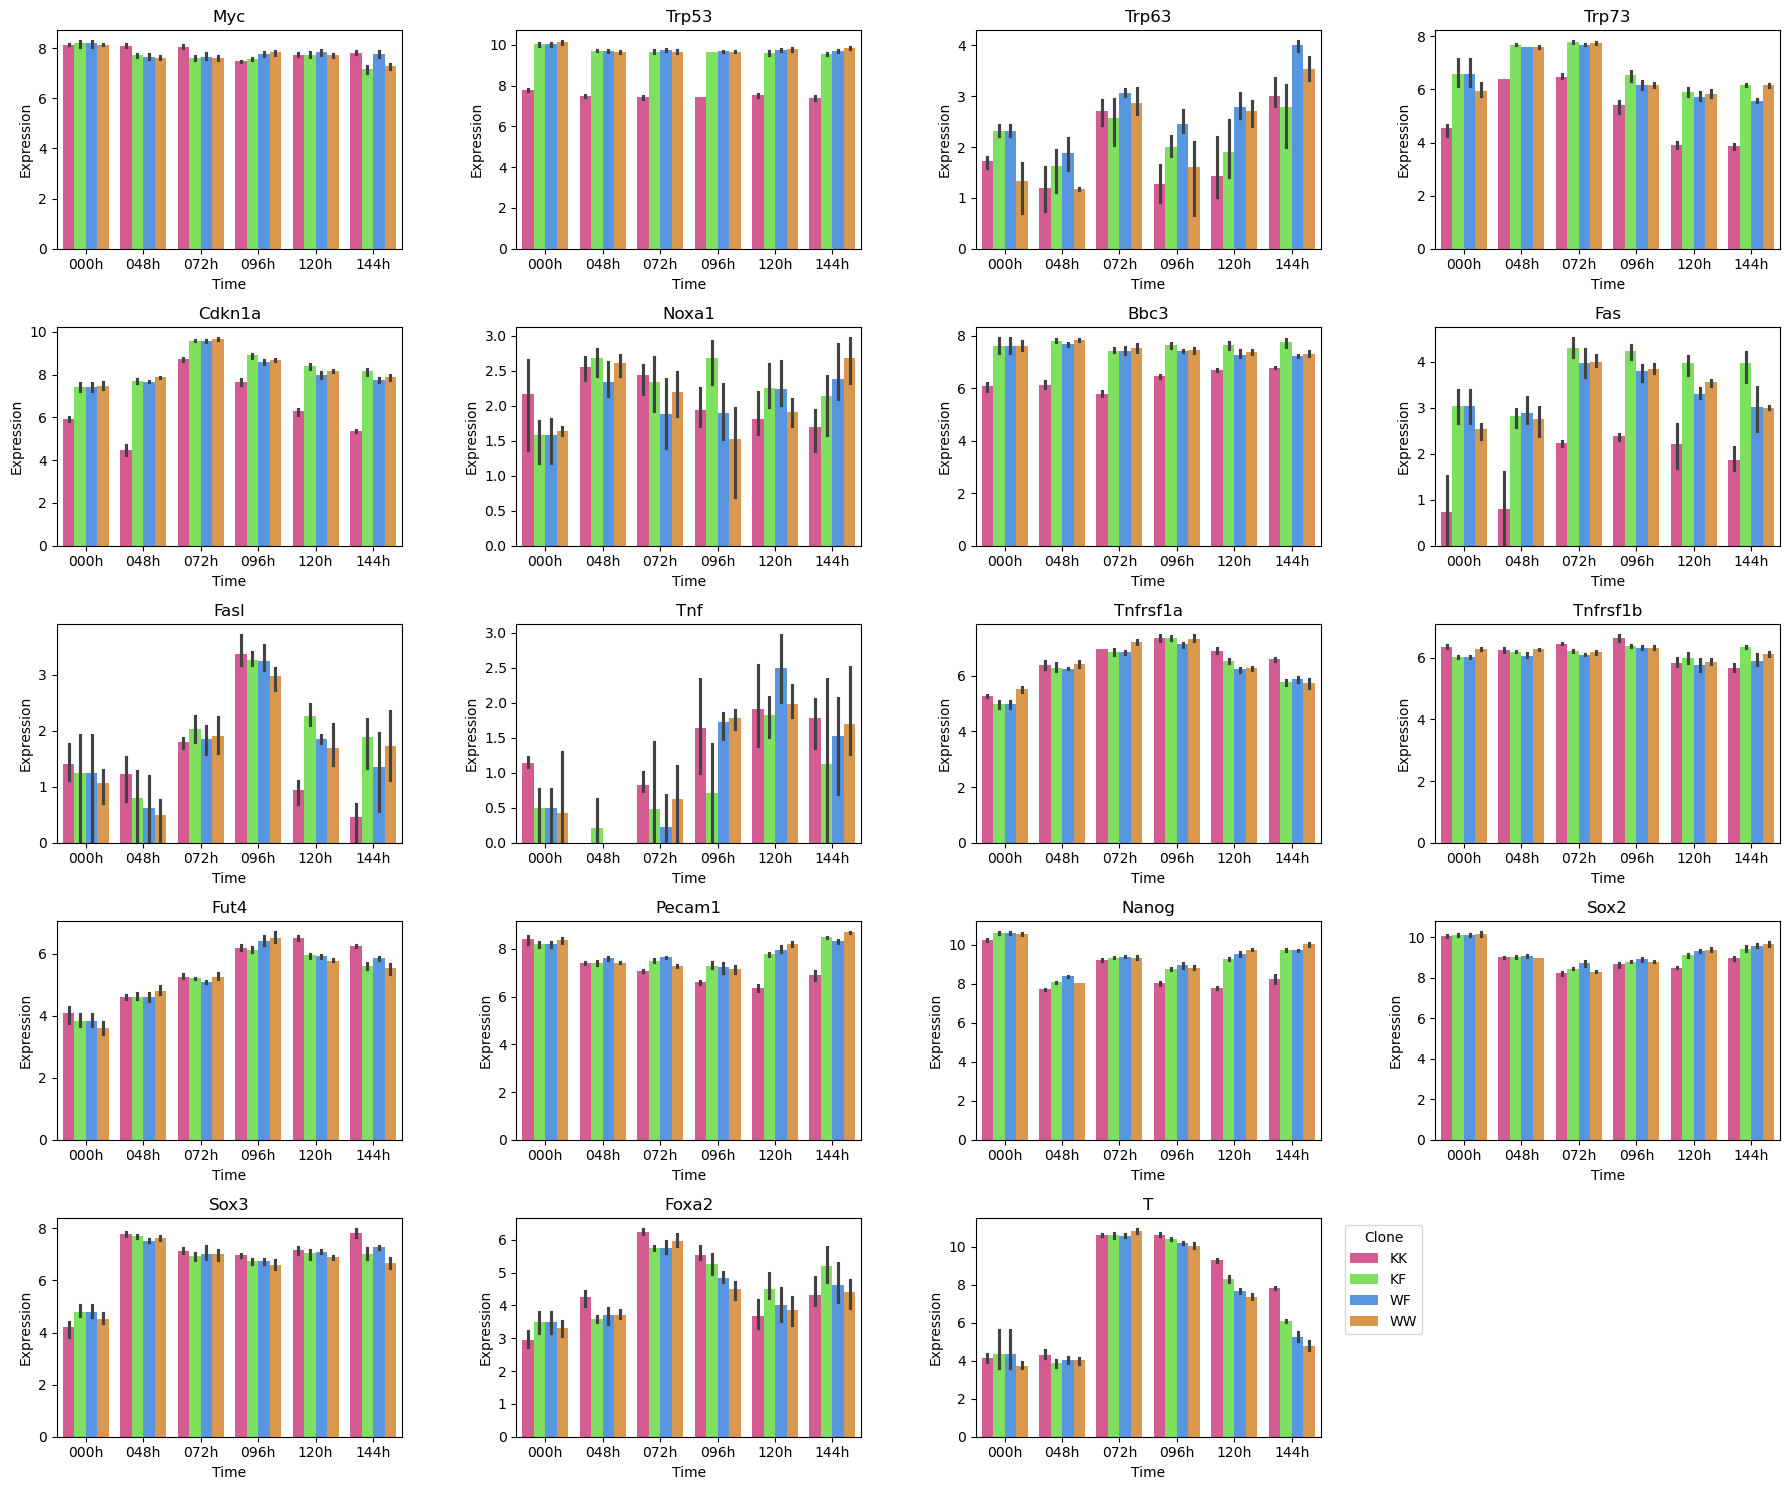

In [ ]:
# Get unique genes for subplots
genes = df_long['Gene'].unique()

# Create a panel of barplots
n_genes = len(genes)
n_cols = 4  # Number of columns in the panel
n_rows = (n_genes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3 * n_rows))
axes = axes.flatten()

for i, gene in enumerate(genes):
    ax = axes[i]
    sns.barplot(
        data=df_long[df_long['Gene'] == gene],
        x='Time', y='Expression', hue='Clone', ax=ax, palette=custom_colors
    )
    ax.set_title(gene)
    ax.set_ylabel('Expression')
    # Remove legend for all subplots except the last one
    if i < len(genes) - 1:
        ax.legend_.remove()
    else:
        ax.legend(title='Clone', bbox_to_anchor=(1.05, 1), loc='upper left')


# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("results/figures/gene_expression_panel.png")
plt.show()